In [1]:
import os
from pathlib import Path

In [2]:
import pandas as pd
from datasets import load_dataset

In [3]:
from huggingface_hub import snapshot_download

In [5]:
image_dir = Path("../data/SkinCAP_images")
assert image_dir.exists() and image_dir.is_dir()

In [18]:
label_path = Path("../data/skincap_labels.csv")
assert label_path.is_file()
df = pd.read_csv(label_path)
df.head()

,id,skincap_file_path,ori_file_path,disease,caption_zh,caption_zh_polish,caption_zh_polish_en,remark,source,skin_tone,...,Umbilicated,Poikiloderma,Salmon,Wheal,Acuminate,Burrow,Gray,Pigmented,Cyst,Do not consider this image
0,1,1.png,000002.png,melanoma-in-situ,发生于足心。可见形状不规则的褐色斑片。建议做病理/皮肤镜检查以明确诊断（色素痣/黑色素瘤）。,在足底出现了形状不规则的褐色斑块，这种情况可能是色素痣或黑色素瘤。建议进行病理学或皮肤镜检查...,Irregular brown patches are present on the sol...,NaN,ddi,56.0,...,0,0,0,0,0,0,0,0,0,0
1,2,2.png,000003.png,mycosis-fungoides,边界清晰的白色斑片。建议做Wood灯、皮肤镜或病理检查，明确是否为白癜风、贫血痣等疾病。,这种描述表明可能存在皮肤上的白色斑块，建议进行Wood灯检查、皮肤镜检查或病理检查，以明确诊...,This description suggests the presence of whit...,NaN,ddi,56.0,...,0,0,0,0,0,0,0,0,0,0
2,3,3.png,000004.png,squamous-cell-carcinoma-in-situ,形状不规范的黑色斑块，中央呈红色。建议做皮肤镜和/或病理学检查，明确是否为脂溢性角化症、基底...,该患者表现为形状不规则的黑色斑块，中央呈红色，需考虑脂溢性角化症、基底细胞癌或黑色素瘤等疾病...,The patient presents with irregularly shaped b...,NaN,ddi,56.0,...,0,0,0,0,0,0,0,0,0,0
3,4,4.png,000005.png,basal-cell-carcinoma,发生于面部。皮损由黑色丘疹和斑疹组成。建议做病理/皮肤镜检查以明确诊断（黑色素瘤）。,面部黑色丘疹和斑疹的皮损可能是黑色素瘤的表现，为了明确诊断建议进行病理学或皮肤镜检查。,The lesion on the face consisting of black pap...,NaN,ddi,12.0,...,0,0,0,0,0,0,0,0,0,0
4,5,5.png,000006.png,squamous-cell-carcinoma,发生于胫前皮肤溃疡。表现为黑色-黄色伤口；边缘轻度隆起。考虑皮肤软组织感染或皮肤肿瘤。,患者出现的症状与胫前皮肤溃疡有关，这种溃疡呈黑色-黄色，边缘轻度隆起，可能是皮肤软组织感染或...,The patient's symptoms are related to a shin s...,NaN,ddi,56.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
image_dir = snapshot_download(
    repo_id="joshuachou/SkinCAP", 
    repo_type="dataset", 
    allow_patterns="skincap/*",
    local_dir=image_dir,
    local_dir_use_symlinks=False
)

/home/fullldiesel/miniconda3/envs/mlx2/lib/python3.12/site-packages/huggingface_hub/file_download.py:832: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 4348 files:   0%|          | 0/4348 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
image_dir

PosixPath('../data/SkinCAP_images')

In [21]:
import os
import pandas as pd
from datasets import Dataset, Features, Image, Value

# Configuration
CSV_PATH = Path("../data/skincap_labels.csv")
BASE_IMAGE_DIR = Path("../data/SkinCAP_images")
rename_cols = {
    "caption_zh_polish_en": "caption",
    "Do not consider this image": "not_considered",
}
REQUIRED_COLUMNS = [
    "skincap_file_path",
    "disease",
    "caption",
    "remark",
    "source",
    "skin_tone",
    "not_considered"
]

# 1. Load and preprocess the CSV
df = pd.read_csv(CSV_PATH)
df.rename(columns=rename_cols, inplace=True)
df = df.loc[:, REQUIRED_COLUMNS]

# 2. Build image paths based on inclusion status
def build_image_path(row):
    base_path = os.path.join(BASE_IMAGE_DIR, "not_include" 
                            if row.get("Do not consider this image") == 9 
                            else "")
    final_path = os.path.join(base_path, os.path.basename(row["skincap_file_path"]))
    return final_path

df["image_path"] = df.apply(build_image_path, axis=1)

# 3. Filter out non-existent images
original_count = len(df)
df = df[df["image_path"].apply(os.path.exists)]
print(f"Filtered {original_count - len(df)} missing images")

# 4. Create dataset with image loading
features = Features({
    "image": Image(),
    "skincap_file_path": Value("string"),
    "disease": Value("string"),
    "caption": Value("string"),
    "remark": Value("string"),
    "source": Value("string"),
    "skin_tone": Value("string"),
    "not_considered": Value("int8"),
})

dataset = Dataset.from_dict({
    "image": df["image_path"].tolist(),
    **{col: df[col].tolist() for col in REQUIRED_COLUMNS}
}, features=features)

# 5. Add filename for reference
dataset = dataset.add_column("filename", [os.path.abspath(p) for p in df["image_path"]])

Filtered 0 missing images


Z-shaped linear red patches appeared on the soles of the patient's feet, and the diagnosis was considered to be nematode infection. Cutaneous nematodes is an inflammatory reaction and tissue damage caused by the invasion of skin by linear miracidia. The diagnosis can be confirmed based on medical history and clinical manifestations such as linear erythema.


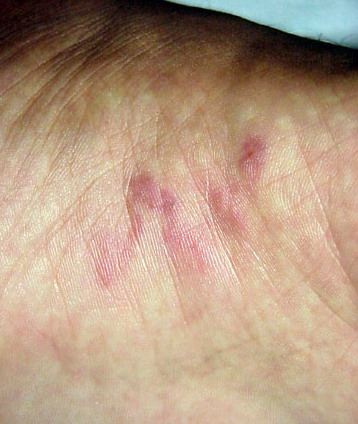

In [22]:
ix = 2000
print(dataset[ix]["caption"])
dataset[ix]["image"]

In [23]:
save_path = Path("../data/skincap_processed")
assert save_path.exists()
dataset.save_to_disk(
    dataset_path=save_path,
)

Saving the dataset (0/3 shards):   0%|          | 0/4000 [00:00<?, ? examples/s]

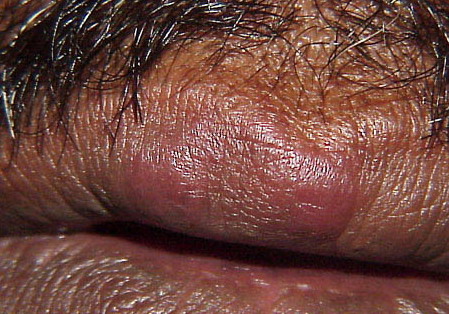

In [49]:
dataset[100]["image"]

In [46]:
dataset[10]

{'image': <PIL.Image.Image image mode=RGBA size=372x305>,
 'skincap_file_path': '11.png',
 'disease': 'squamous-cell-carcinoma-keratoacanthoma',
 'caption': 'Without sufficient information from the image, it is not possible to make an accurate diagnosis. It is recommended that the patient seeks medical attention for a comprehensive physical examination and medical assessment.',
 'remark': 'nan',
 'source': 'ddi',
 'skin_tone': '56.0',
 'not_considered': 0,
 'filename': '/home/fullldiesel/Software/learning/MLX/Coda/derma-cot/data/SkinCAP_images/11.png'}